In [1]:
%pip install boto3 nibabel numpy matplotlib
%pip install --upgrade nibabel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Fetching file: BraTS20_Training_369_flair.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmpe8mxaf8g.nii
Data shape for BraTS20_Training_369_flair.nii: (240, 240, 155)


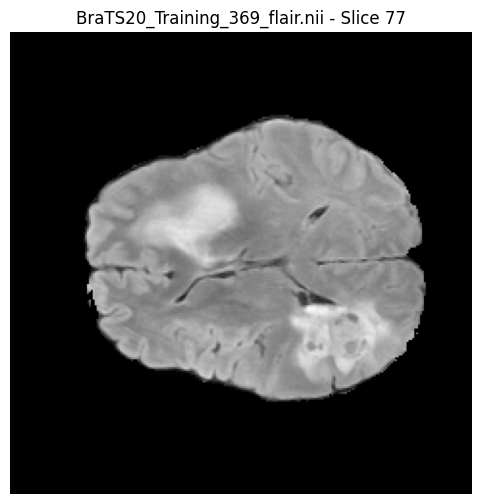

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmpe8mxaf8g.nii
Fetching file: BraTS20_Training_369_seg.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmph3etvxr0.nii
Data shape for BraTS20_Training_369_seg.nii: (240, 240, 155)


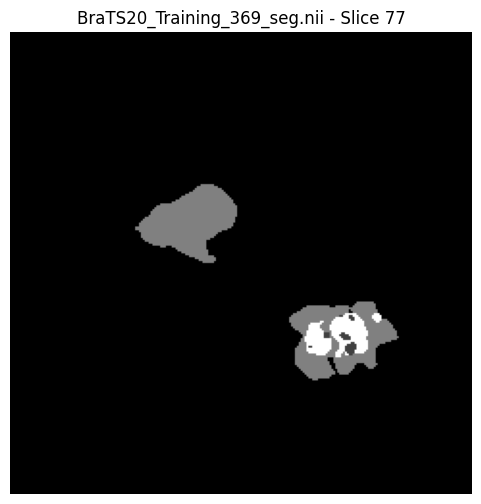

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmph3etvxr0.nii
Fetching file: BraTS20_Training_369_t1.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmpasy8p8rx.nii
Data shape for BraTS20_Training_369_t1.nii: (240, 240, 155)


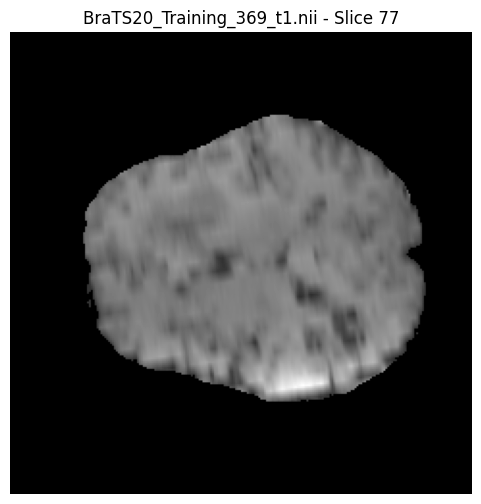

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmpasy8p8rx.nii
Fetching file: BraTS20_Training_369_t1ce.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmpj1bqffiv.nii
Data shape for BraTS20_Training_369_t1ce.nii: (240, 240, 155)


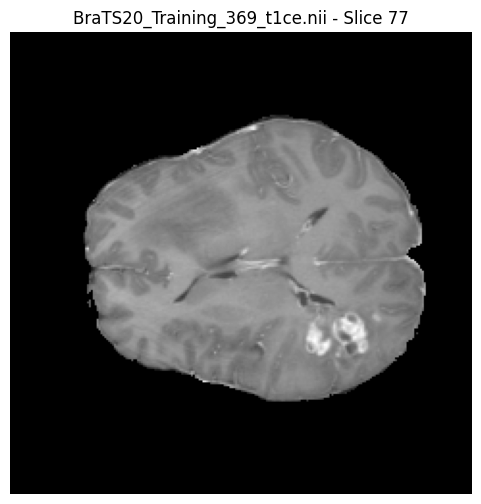

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmpj1bqffiv.nii
Fetching file: BraTS20_Training_369_t2.nii
Temporary file created: C:\Users\grnpr\AppData\Local\Temp\tmpkagvjgsv.nii
Data shape for BraTS20_Training_369_t2.nii: (240, 240, 155)


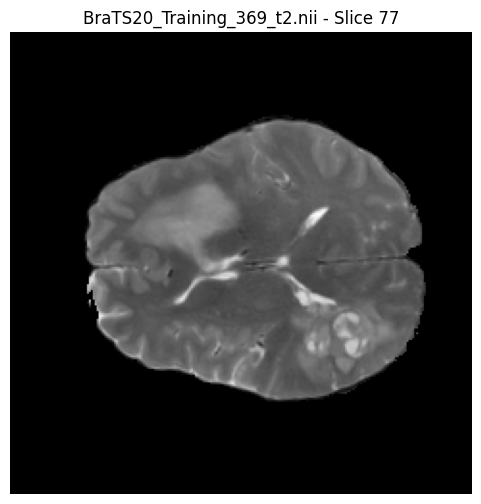

Deleted temporary file: C:\Users\grnpr\AppData\Local\Temp\tmpkagvjgsv.nii


In [2]:
import boto3
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import io
import tempfile
import os

s3 = boto3.resource('s3')
bucket_name = 'chemocraft-data'
folder_path = 'Data/BraTS20_Training_369 copy/'
bucket = s3.Bucket(bucket_name)

def render_nii_from_s3(filename):
    print(f"Fetching file: {filename}")

    obj = bucket.Object(folder_path + filename)
    file_stream = io.BytesIO(obj.get()['Body'].read())

    with tempfile.NamedTemporaryFile(suffix='.nii', delete=False) as temp_file:  # Disable auto-delete
        temp_file.write(file_stream.getvalue())
        temp_file.flush()

        temp_file_path = temp_file.name
        print(f"Temporary file created: {temp_file_path}")

    try:
        img = nib.load(temp_file_path)
        data = img.get_fdata()

        print(f"Data shape for {filename}: {data.shape}")

        if data.size == 0:
            print(f"No data found in {filename}")
            return

        slice_idx = data.shape[2] // 2

        plt.figure(figsize=(6, 6))
        plt.imshow(data[:, :, slice_idx], cmap='gray')
        plt.title(f'{filename} - Slice {slice_idx}')
        plt.axis('off')  # Hide axes for cleaner display
        plt.show()

    except Exception as e:
        print(f"Error loading file {filename}: {e}")
    finally:
        try:
            os.remove(temp_file_path)  # Clean up the temp file
            print(f"Deleted temporary file: {temp_file_path}")
        except OSError as cleanup_error:
            print(f"Error deleting temp file: {cleanup_error}")

found_files = False
for obj in bucket.objects.filter(Prefix=folder_path):
    if obj.key.endswith('.nii'):
        found_files = True
        filename = obj.key.split('/')[-1]  # Get the filename
        render_nii_from_s3(filename)

if not found_files:
    print(f"No .nii files found in the folder {folder_path}")
